In [69]:
%load_ext autoreload
%autoreload 2
import emcee
import corner
import pickle
import numpy as np
import pandas as pd

from astropy import units as u
from astropy import constants as const
from astropy.table import QTable
from matplotlib import pyplot as plt
from scipy.optimize import root, brentq
from uncertainties import ufloat
from uncertainties.umath import *
from uncertainties import unumpy as unp

from load_mcxc_data import load_clusters
from cluster_functions import c
from statistics_functions import chi_squared
from equilibrium_functions import equil
from cluster import Cluster

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
clusters, variances=load_clusters(nrows=20)

In [59]:
def load_clusters1(nrows=None, dataset='REFLEX'):
    skipfooter=0 if nrows else 1
    mcxccls=pd.read_csv('data/mcxc|.txt', header=3, sep='|', skiprows=[4],on_bad_lines='warn', skipfooter=skipfooter)
    mcxccls.columns=mcxccls.columns.str.strip()

    selected_cls=mcxccls[mcxccls['Sub-Cat'].str.strip()==dataset]


    cls_data={'M500':selected_cls['M500'],
          'L500':selected_cls['L500'],
          'R500':selected_cls['R500']
         }
    units={
        'M500': 1e14*u.Msun,
        'L500': 1e37*u.W,
        'R500':u.Mpc
    }

    cls_table=QTable(cls_data, units=units)
    
    with open ('data/'+dataset+'.p', 'rb') as fp:
        L_uncertainties=np.array(pickle.load(fp))
    L_uncertainties_conv=(L_uncertainties*1e37*u.W).to(u.erg / u.s).value
    
    return [ 
        Cluster(
            cls_table['R500'][i],
            cls_table['M500'][i],
            L500=cls_table['L500'][i],
            m500=cls_table['M500'][i],
        )
        for i in range(nrows)#(mcxccls.shape[0])
    ], [variance(cls_table['L500'][i], L_uncertainties_conv[i]) for i in range(nrows)] 

In [52]:
def variance1(luminosity, l_unc): # returns the variance on calculated temperature
     # TODO: TEST THIS NOW THAT I HAVE ADDED L_unc
    #logL=np.log10((luminosity.to(1e44*u.erg/u.s))/(1e44*u.erg/u.s))

    A=ufloat(2.88, 0.15)
    B=ufloat(45.06, 0.03)

    lum = luminosity.to(u.erg / u.s)
    
    lums_uf = ufloat(lum.value, l_unc)
    log_T = (unp.log10(lums_uf) - B) / A + np.log10(6)
    #T = (10**log_T * u.keV).to(u.GeV)

    T = 10**log_T * 1e-6 #divide by 10^6 to convert keV to GeV

    return T.std_dev *u.GeV #variances on T in GeV

In [75]:
#prepare MCMC
ndim, nwalkers = 2, 10
p0=np.zeros((nwalkers, ndim ))
log_sigma0 = np.random.uniform(low=-50, high=0, size=nwalkers).astype(np.float128)
log_mx = np.random.uniform(low=-3, high=0, size=nwalkers).astype(np.float128)
p0[:,0]=log_sigma0
p0[:,1]=log_mx
p0

array([[-22.5122234 ,  -2.63546169],
       [-30.19701663,  -0.45880908],
       [ -7.25565704,  -0.35174945],
       [-39.28375782,  -1.43001952],
       [ -4.78488287,  -0.1217946 ],
       [-36.86899604,  -2.19076041],
       [-40.53327662,  -0.08109702],
       [-16.07225164,  -0.31482522],
       [-25.7098929 ,  -0.18118117],
       [-10.12953714,  -2.6615778 ]])

In [76]:
T_data = [c.baryon_temp for c in clusters]

In [81]:
def log_lik(p0, T_data, var, clusters):
    if p0[0]<-50 or p0[0]>0:
        return -np.inf
    if p0[1]<-3 or p0[1]>0:
        return -np.inf
    #print(p0)
    T_model = [brentq(equil, -15, 0, args=(c, p0[0], p0[1])) for c in clusters]
    X2 = chi_squared(np.power(10,T_model)*u.GeV, T_data, var)
    return (-X2/2)

In [82]:
log_lik(p0[0], T_data, variances, clusters)

<Quantity -2111.56446107>

In [83]:
n=0
sampler = emcee.EnsembleSampler(
    nwalkers, 
    ndim, 
    log_lik, 
    args=[T_data, variances, clusters])

In [84]:
state = sampler.run_mcmc(p0, 100, progress=True)
sampler.reset()

100%|█████████████████████████████████████████| 100/100 [07:08<00:00,  4.28s/it]


In [85]:
sampler.run_mcmc(state, 500, progress=True)

100%|█████████████████████████████████████████| 500/500 [39:45<00:00,  4.77s/it]


State([[-22.32668582  -0.15990106]
 [-17.14192732  -0.13032789]
 [-22.55324806  -0.17661308]
 [-23.89524275  -2.98235859]
 [-22.23842723  -0.15659821]
 [-22.49497475  -0.16138405]
 [-22.30777689  -0.15336007]
 [-11.68500388  -0.12914274]
 [-22.17091282  -0.14491294]
 [-22.60529896  -0.19111178]], log_prob=[ -0.36929975  -6.76742821  -1.45082279 -92.57457235  -0.76913826
  -3.42513275  -0.8032536   -6.53982092  -1.32269776  -1.93688906], blobs=None, random_state=('MT19937', array([2015126384, 1918809695, 1398114653, 4123011009,  501828225,
       1690259596, 1159441488,  412946478,  668086496, 2907543408,
       1745926039, 3998814104, 3706536029, 2087447498, 3469053145,
       2721836141, 1687647103, 2526424691, 3224449164, 3714742399,
       3743346217, 1242069902, 2633850332, 3240334701, 1220676724,
       3831575811, 2913691909, 3654739488,  768180184,  544154147,
       3904651934,  288173404,  827028554, 1738163921, 4182090476,
         97629238, 1693121376, 4094873103,  424925457

In [86]:
samples = sampler.get_chain(flat=True)

In [87]:
"Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction))

'Mean acceptance fraction: 0.282'

(5000, 2)


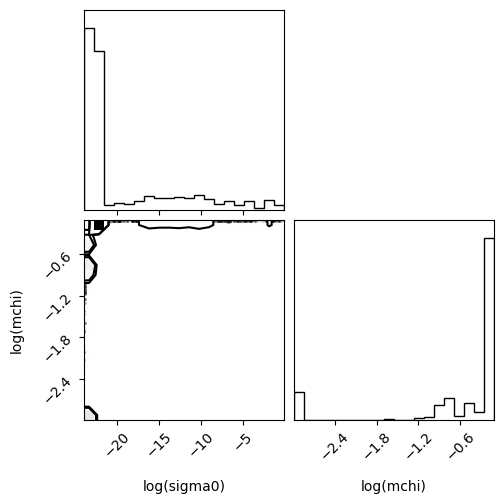

In [88]:
flat_samples = sampler.get_chain(flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=['log(sigma0)', 'log(mchi)'])